### 10. Układ 100-stanowy

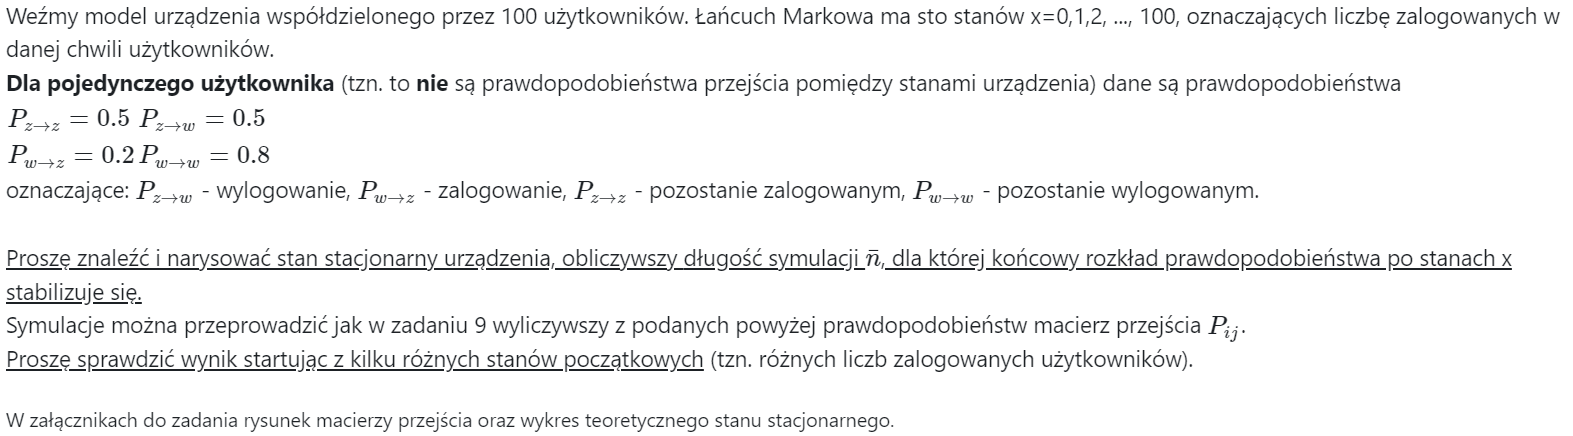

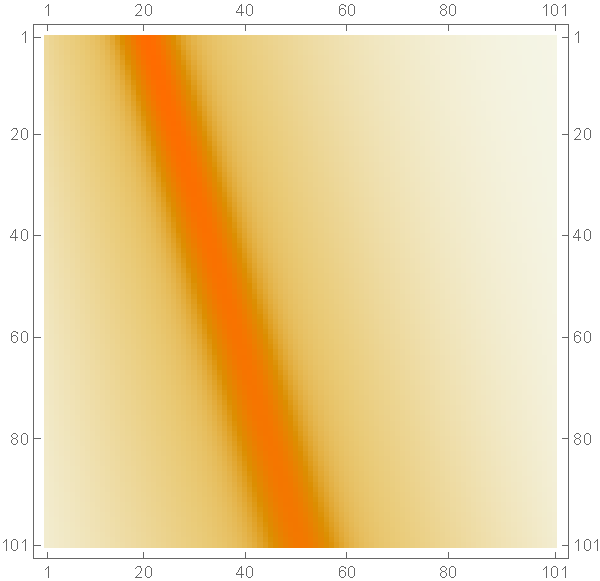

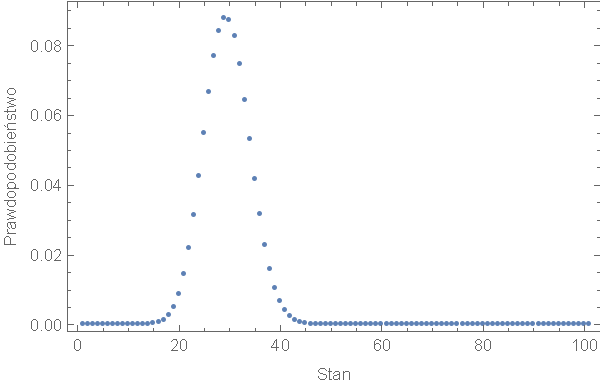

In [1]:
import numpy as np
from scipy.stats import binom
import matplotlib.pyplot as plt

In [2]:
N_LOGGED = N_STATES = 100
Pzz, Pzw, Pwz, Pww = 0.5, 0.5, 0.2, 0.8
# transition matrix P[i, j] represents the probability of
# going from state i (i users logged in) to state j (j users logged in)
P = np.zeros((N_STATES, N_STATES)) # NOT EMPTY!

$P[i, j] = \sum_{k=\max(0, j - (100 - i))}^{\min(i, j)} \binom{i}{k} (0.5)^k (0.5)^{i - k} \cdot \binom{100 - i}{j - k} (0.2)^{j - k} (0.8)^{(100 - i) - (j - k)}$


Spośród i zalogowanych użytkowników, losujemy k, którzy pozostaną zalogowani, a i-k się wyloguje.

Spośród 100-i niezalogowanych użytkowników, losujemy j-k, którzy się zalogują, a (100-i)-(j-k) pozostanie wylogowanych. J-k to takie jakby dopełnienie do tych k użytkowników, którzy pozostali zalogowani (j to nasza docelowa liczba użytkowników).

Iterujemy po k, bo jeśli chcemy przejść np. z 40 do 60 użytkowników, to jest wiele opcji:
* 20 (k) może pozostać zalogowanymi, a 40 (j-k) dopiero się zalogować
* 23 (k) może zostać, a 27 (j-k) się zalogować
* 40 (k) może zostać, a 20 (j-k) się zalogować
* itd.

Jednak k nie może być mniejsze, niż j-(100-i), gdzie 100-i to liczba wylogowanych użytkowników. Liczba użytkowników, którzy pozostaną zalogowani musi być co najmniej taka, jak docelowa liczba użytkowników, pomniejszona o użytkowników wylogowanych. 

j-k <= 100-i (liczba użytkowników do zalogowania nie może być większa niż liczba użytkowników wylogowanych), więc:

k >= j-(100-i)

---

P[i, j] to przejście z i zalogowanych użytkowników do j zalogowanych użytkowników.

j-i to użytkownicy, którzy muszą się zalogować, żeby przejść z i do j.

i-k to 'straceni' użytkownicy z poprzedniego stanu, przez wylogowanie się.

j-i + i-k = j-k to potrzebni do zalogowania nowi użytkownicy, z puli niezalogowanych.

---

Użytkownik, tak jak ja to rozumiem, nie może więcej niż jeden raz zmienić stanu podczas jednego przejścia, t.j np. wylogować się, a następnie zalogować się ponownie

In [3]:
for i in range(N_LOGGED):    
    # prob of ...
    stay_logged_in_probs = binom.pmf(range(i+1), i, Pzz) 
    # zwraca pp dla k od 0 do i włącznie // O WIELE szybsze (17s/11s vs 34s) niż w ostatniej pętli
    for j in range(N_LOGGED):
        users_logged_out = N_LOGGED - i
        
        # probability of j - k users logging in (where k is the number who stayed logged in)
        for k in range(max(0, j - users_logged_out), min(i, j) + 1):
            # stay_logged_in_probs = binom.pmf(k, i, Pzz)
            logged_in_probs = binom.pmf(j - k, users_logged_out, Pwz)
            P[i, j] += logged_in_probs * stay_logged_in_probs[k]

Poniżej widać, że dla stanu "0", który oznacza 0 zalogowanych użytkowników, macierz przejścia P przyjmuje największe wartości około stanu "20", czyli 20 zalogowanych użytkowników. Oznacza to, że przejście do stanu "20" lub w jego okolice jest dla stanu "0" najbardziej prawdopodobne. 20 zalogowanych użytkowników to 20% z wszystkich 100 użytkowników. 20% to również prawdopodobieństwo zalogowania się użytkownika, jeśli był wcześniej wylogowany. Ma to więc sens. Obrazek ten odpowiada również obrazkowi podanemu w treści zadania.

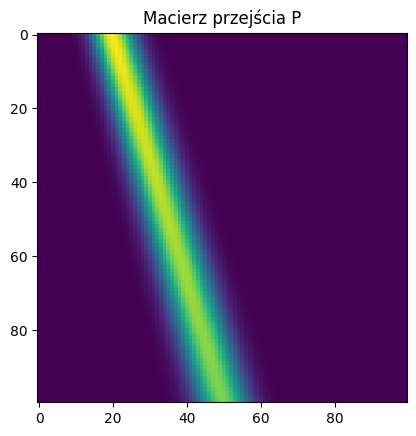

In [4]:
plt.title("Macierz przejścia P")
plt.imshow(P);

In [5]:
# just some quick checks
# https://discuss.python.org/t/using-assignment-expressions-inside-f-strings/33066
print(f"P[0] argmax: {(a:=np.argmax(P[0]))}\nP[0][argmax]: {P[0][a]}\nP[0].shape: {P[0].shape}\nsum(P[0]): {sum(P[0])}")

P[0] argmax: 20
P[0][argmax]: 0.09930021480882459
P[0].shape: (100,)
sum(P[0]): 0.9999999999999998


Znajdowanie stanu stacjonarnego (potęgi macierzy P):

In [25]:
# make that a function?
err = 999
power = 1
P_current = P.copy()

while err > 1e-5:
    P_prev = P_current.copy()
    P_current = P_current @ P # or maybe raise P to a specific power using linalg.matrix_power
    power += 1
    # err = np.abs(P_current[0,0]-P_prev[0,0])
    err = np.linalg.norm(P_current - P_prev) # Frobenius norm: https://mathworld.wolfram.com/FrobeniusNorm.html#:~:text=The%20Frobenius%20norm%2C%20sometimes%20also,considered%20as%20a%20vector%20norm.
    print(f"power: {power}, err: {err}")

power: 2, err: 2.1022675693762056
power: 3, err: 0.8229887267963722
power: 4, err: 0.26019429212872597
power: 5, err: 0.07895613150406249
power: 6, err: 0.023757987375175895
power: 7, err: 0.007133526918443756
power: 8, err: 0.002140602386297728
power: 9, err: 0.0006422295018947034
power: 10, err: 0.0001926732358498958
power: 11, err: 5.780236528291529e-05
power: 12, err: 1.7340745088417522e-05
power: 13, err: 5.202226721701145e-06


In [83]:
N = 10_000 # 1_000 ~ 40 secs // 10_000 ~ 3 mins
STEPS = power
ending_states = np.zeros((N_STATES, N), dtype=int) # or empty?
err = 999

for starting_state in range(N_STATES):
    # print(starting_state)
    for n in range(N):
        state = starting_state
        for step in range(STEPS):
            state = np.random.choice(N_STATES, p=P[state]) # transition to a new state
        ending_states[starting_state, n] = state

In [84]:
# https://numpy.org/doc/stable/reference/generated/numpy.bincount.html
stationary_state_estims = np.array([
    np.bincount(ending_states[starting_state], minlength=N_STATES)/N
    for starting_state in range(N_STATES)
])
print(stationary_state_estims.shape)

(100, 100)


Stan stacjonarny macierzy przejść P odpowiada podanemu w treści zadania.

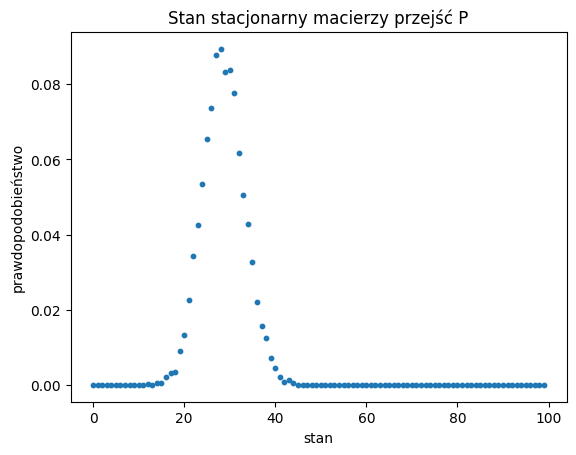

In [86]:
plt.title("Stan stacjonarny macierzy przejść P")
plt.xlabel("stan")
plt.ylabel("prawdopodobieństwo")
plt.scatter(range(N_STATES), stationary_state_estims[0], s=10);